# init

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../infras/')
sys.path.append('../experiments/')
sys.path.append('../experiments/pipeline/')
sys.path.append('../preprocess/cell_specifics/')
sys.path.append('../preprocess/intra_variance/')
sys.path.append('../models/cell_proportions/')
sys.path.append('../measures/cell_proportions_measures/')

In [2]:
from data_factory import DataFactory

from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments

from basic import BasicDeconv
from pp_entropy_based import PpEntropyBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv

In [3]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools
from tqdm import tqdm

from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import os
import pickle as pkl 

In [4]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

from cellMix_coordinator import CellMixCoordinator

In [5]:
import shap

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


## build grid params to results simulation 

In [6]:
data_factory = DataFactory()
A_all_vs,_ = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x,log2_transformation=True)

Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.


In [7]:
_,X,B = data_factory.build_simulated_data()

In [8]:
agg_iv = AggregateIntraVariance()
#cleen irrelevant
pp_irl_prot = PpCleanIrrelevantProteins()

#possible pre process
pp_entropy_only_largest = PpEntropyBasedOnlyLargest(with_norm=True)

# deconv
bd = BasicDeconv()

# measure
cpm = CellProportionsMeasure()


In [9]:
hyper_configuration = [{"step_name":"AggregateIntraVariance",
                       "steps":[
                           {"function_name":"AggregateIntraVariance","function":agg_iv,
                            "params" :{"how" : ["mean"]} }]},
                       #--------------------------------
                        {"step_name":"cleen_irrelevant_proteins",
                       "steps":[
                           {"function_name":"CleanIrrelevantProteins","function":pp_irl_prot,
                            "params" :{} }]},
                       #--------------------------------
                        {"step_name":"preprocess",
                       "steps":[
                           {"function_name":"PpEntropyBasedOnlyLargest","function":pp_entropy_only_largest,
                            "params" :{"n_genes_per_cell":[15],"with_norm" : [True]} },
                       ]},
                       #--------------------------------
                       {"step_name":"deconv",
                       "steps":[
                           {"function_name":"BasicDeconv","function":bd,
                            "params" :{"normalize":[True],"cellMix":[False]}}]} ]

hyper_measure_configuration = [
                        {"step_name":"measure",
                       "steps":[
                           {"function_name":"CellProportionsMeasure","function":cpm,
                            "params" :{"how":["correlation"] } }]}]

simulation_pipe = PipelineDeconv(hyper_configuration=hyper_configuration,hyper_measure_configuration=hyper_measure_configuration)
simulation_pipe.run_pipeline(A_all_vs,B,X) 

[{'corrMean': 0.274, 'corrStd': 0.109, 'corrNnan': 0.0}]

In [65]:
count = 0 
parmas_to_results = []
with tqdm(total = 5*5*5*3) as pbar:
    for percantage_to_zero in np.linspace(0.01,0.9,5):
        for kurtosis_of_low_abundance in np.linspace(0.1,3,5) :
            for saturation in np.linspace(0.1,1,5):
                for unquantified_cell_percentage in [5,30,60]:
                    _,X,B = data_factory.build_simulated_data(percantage_to_zero=percantage_to_zero,kurtosis_of_low_abundance=kurtosis_of_low_abundance,saturation=saturation,unquantified_cell_percentage=unquantified_cell_percentage)
    #                 try : 
                    simulation_pipe = PipelineDeconv(hyper_configuration=hyper_configuration,hyper_measure_configuration=hyper_measure_configuration)
                    res_dic = simulation_pipe.run_pipeline(A_all_vs,B,X) 
                    res = res_dic[0]["corrMean"]
                    parmas_to_results.append([percantage_to_zero,kurtosis_of_low_abundance,saturation,unquantified_cell_percentage,res])
                    pbar.update(1)
    #                 print(count)
    #                 except : 
    #                     print(f"{percantage_to_zero}_{quantile_normalization_salt_noise}_{unquantified_cell_percentage}")
    #                     print(res_dic)
all_results = pd.DataFrame(columns=["percantage_to_zero","kurtosis_of_low_abundance","saturation","unquantified_cell_percentage","result"],data=parmas_to_results)
# percantage_to_zero =0.1,quantile_normalization_salt_noise = 0.8,unquantified_cell_percentage = 30

  0%|                                                                                          | 0/375 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [57]:
def suc(k,a) :
    return (a*(k**(k+1)))/(k+1)

all_results["powerlawparam"] = all_results["powerlawparam"] = all_results.apply(lambda row:suc(row["kurtosis_of_low_abundance"],row["saturation"]),axis=1)

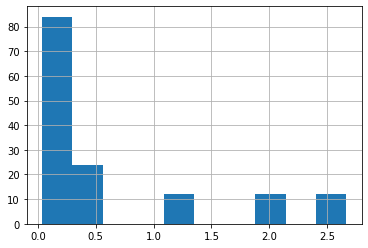

In [62]:
all_results["powerlawparam"].hist()

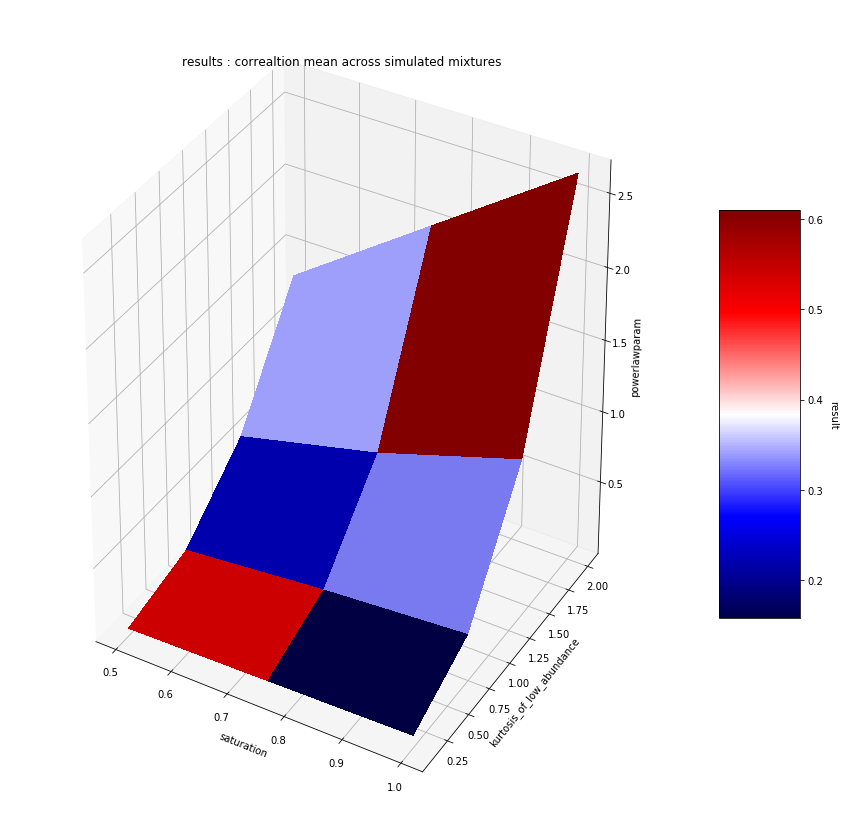

In [58]:
list_name_variables = ["saturation","kurtosis_of_low_abundance","powerlawparam","result"]
plot_four_dim_results(all_results,list_name_variables)

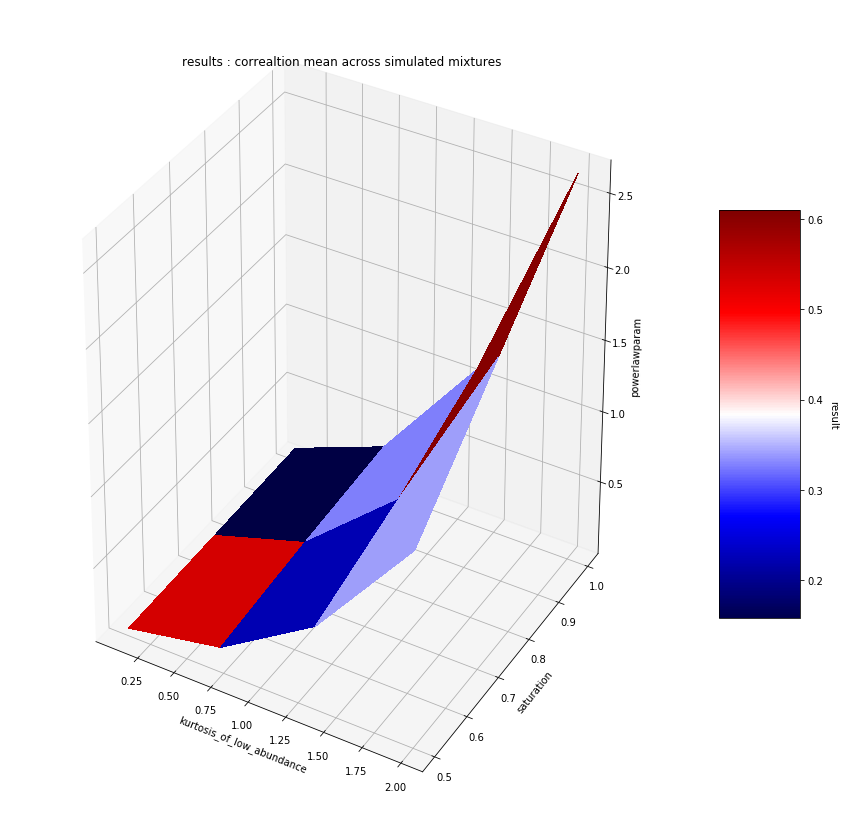

In [63]:
list_name_variables = ["kurtosis_of_low_abundance","saturation","powerlawparam","result"]
plot_four_dim_results(all_results,list_name_variables)

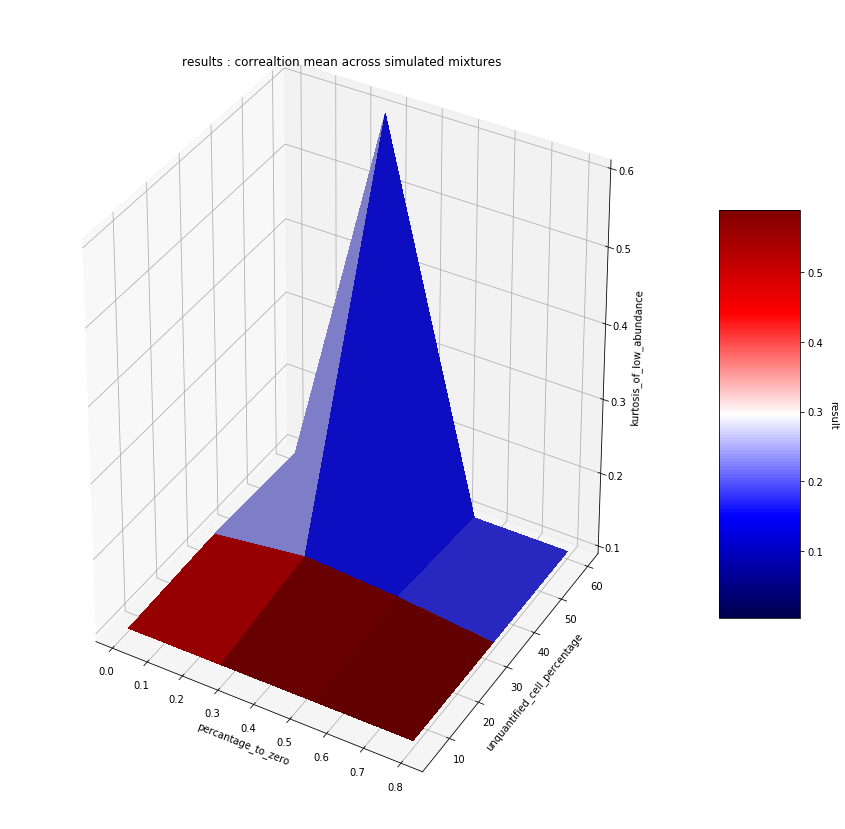

In [64]:
list_name_variables = ["percantage_to_zero","unquantified_cell_percentage","kurtosis_of_low_abundance","result"]
plot_four_dim_results(all_results,list_name_variables)

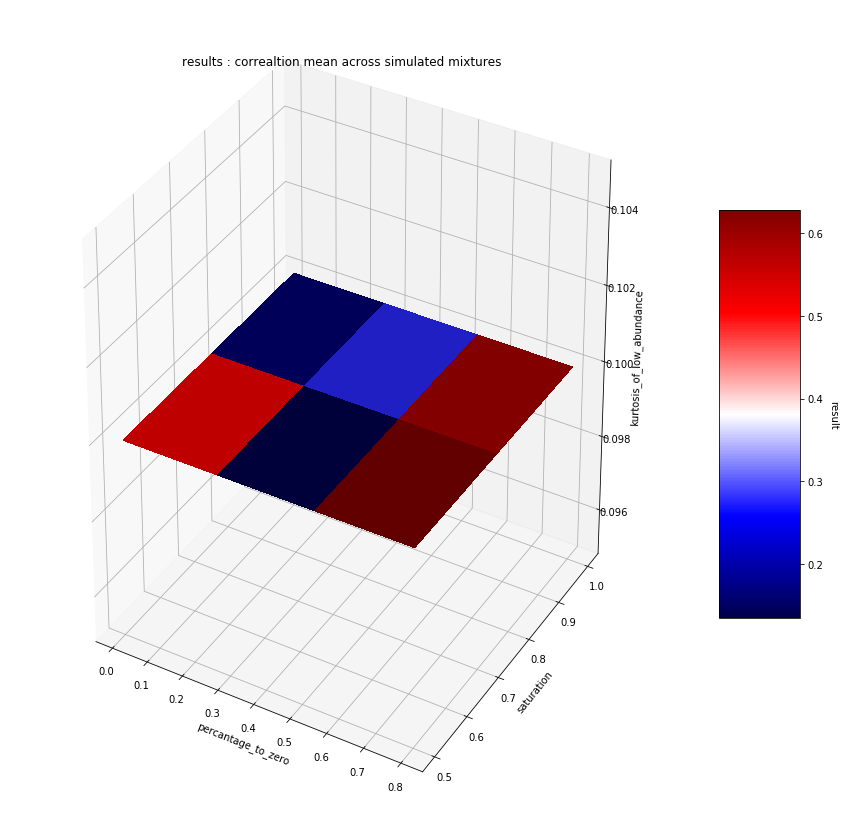

In [50]:
import matplotlib
from scipy.interpolate import griddata

def plot_four_dim_results(all_results,list_name_variables):
    index_x = 0; index_y = 1; index_z = 2; index_c = 3
    x = all_results[list_name_variables[index_x]]
    y = all_results[list_name_variables[index_y]]
    z = all_results[list_name_variables[index_z]]
    c = all_results[list_name_variables[index_c]]

    name_color_map = 'seismic';

    # X-Y are transformed into 2D grids. It's like a form of interpolation
    x1 = np.linspace(x.min(), x.max(), len(np.unique(x))); 
    y1 = np.linspace(y.min(), y.max(), len(np.unique(y)));
    x2, y2 = np.meshgrid(x1, y1);

    # Interpolation of Z: old X-Y to the new X-Y grid.
    # Note: Sometimes values can be < z.min and so it may be better to set 
    # the values too low to the true minimum value.
    z2 = griddata( (x, y), z, (x2, y2), method='cubic', fill_value = 0);
    z2[z2 < z.min()] = z.min();

    # Interpolation of C: old X-Y on the new X-Y grid (as we did for Z)
    # The only problem is the fact that the interpolation of C does not take
    # into account Z and that, consequently, the representation is less 
    # valid compared to the previous solutions.
    c2 = griddata( (x, y), c, (x2, y2), method='cubic', fill_value = 0);
    c2[c2 < c.min()] = c.min(); 

    #--------
    color_dimension = c2; # It must be in 2D - as for "X, Y, Z".
    minn, maxx = color_dimension.min(), color_dimension.max();
    norm = matplotlib.colors.Normalize(minn, maxx);
    m = plt.cm.ScalarMappable(norm=norm, cmap = name_color_map);
    m.set_array([]);
    fcolors = m.to_rgba(color_dimension);

    # At this time, X-Y-Z-C are all 2D and we can use "plot_surface".
    fig = plt.figure(figsize=(15,15)); ax = fig.gca(projection='3d');
    surf = ax.plot_surface(x2, y2, z2, facecolors = fcolors, linewidth=0, rstride=1, cstride=1,
                           antialiased=False);
    cbar = fig.colorbar(m, shrink=0.5, aspect=5);
    cbar.ax.get_yaxis().labelpad = 15; cbar.ax.set_ylabel(list_name_variables[index_c], rotation = 270);
    ax.set_xlabel(list_name_variables[index_x]); ax.set_ylabel(list_name_variables[index_y]);
    ax.set_zlabel(list_name_variables[index_z]);
    plt.title('results : correaltion mean across simulated mixtures' );
    plt.show(); 

list_name_variables = ["percantage_to_zero","saturation","kurtosis_of_low_abundance","result"]
plot_four_dim_results(all_results,list_name_variables)

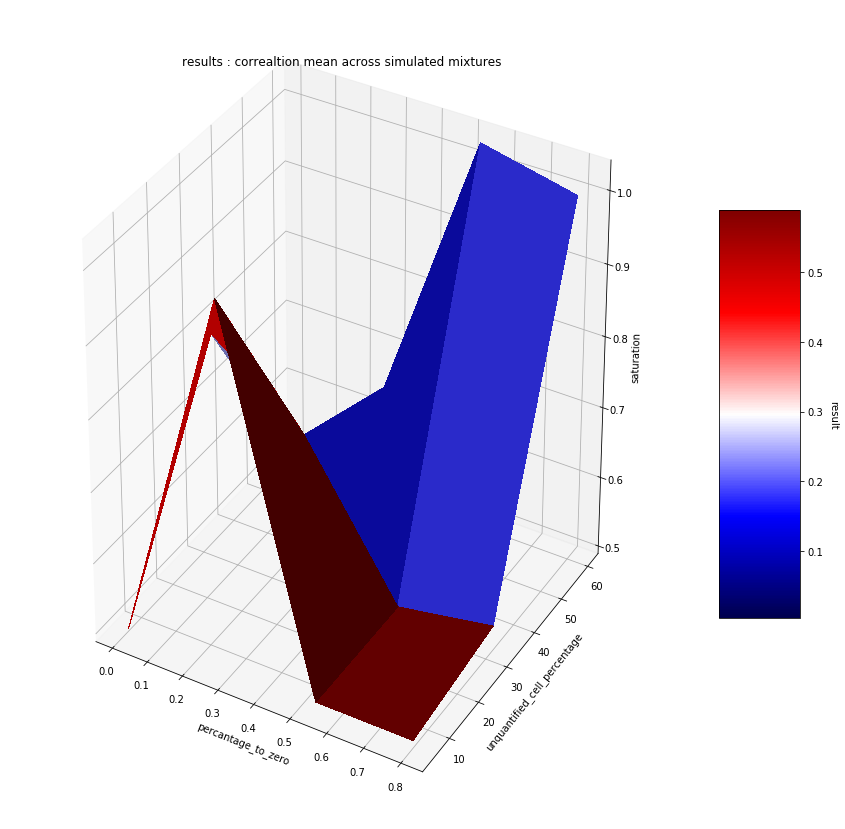

In [34]:
list_name_variables = ["percantage_to_zero","unquantified_cell_percentage","saturation","result"]
plot_four_dim_results(all_results,list_name_variables)

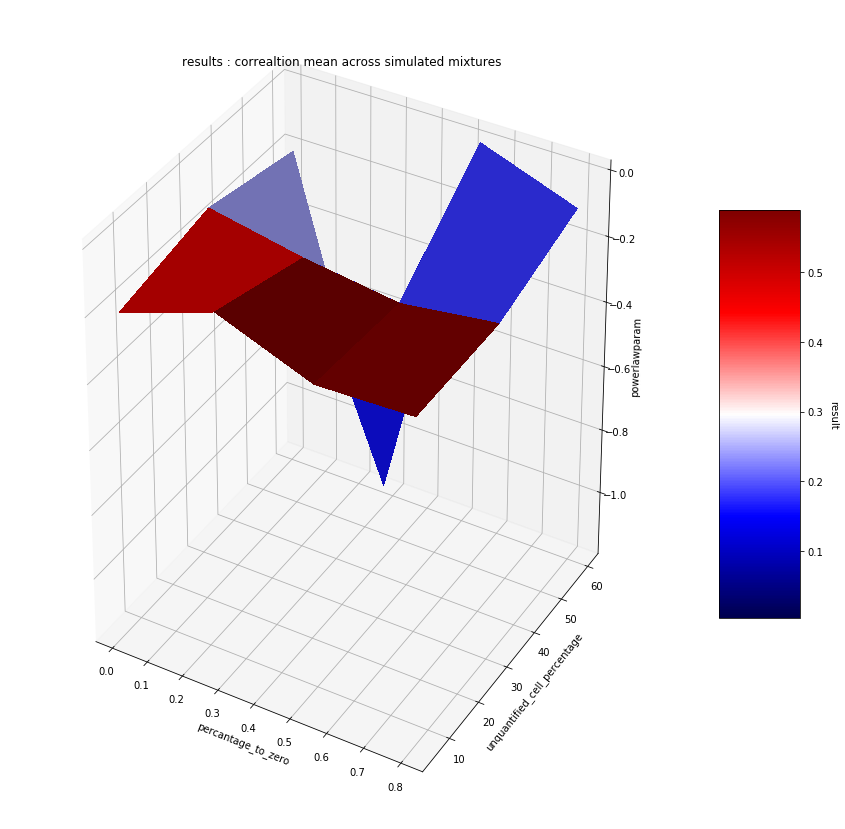

In [51]:
list_name_variables = ["percantage_to_zero","unquantified_cell_percentage","powerlawparam","result"]
plot_four_dim_results(all_results,list_name_variables)

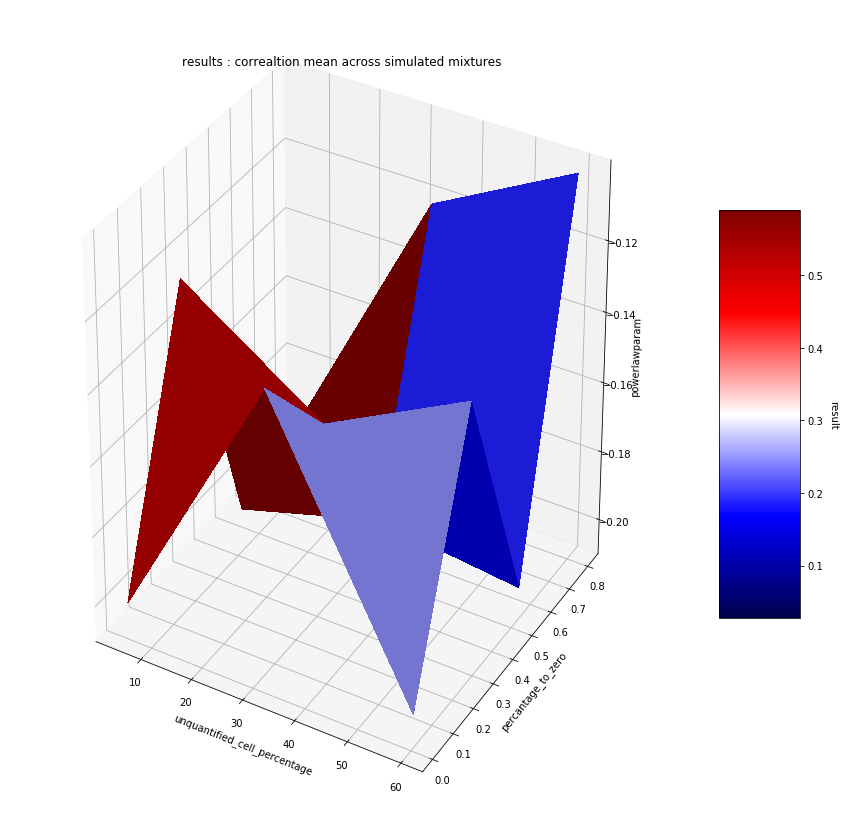

In [52]:
list_name_variables = ["unquantified_cell_percentage","percantage_to_zero","powerlawparam","result"]
plot_four_dim_results(all_results,list_name_variables)

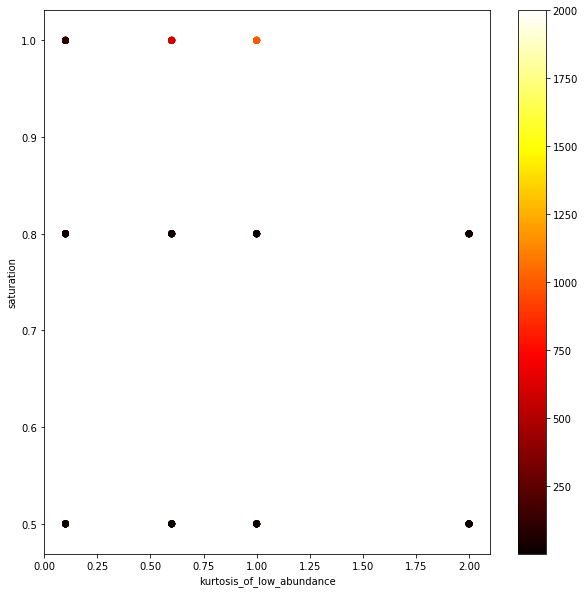

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

x = all_results["kurtosis_of_low_abundance"]
y = all_results["saturation"]
c = all_results["powerlawparam"]

img = ax.scatter(x, y, c=c, cmap=plt.hot())
ax.set_xlabel("kurtosis_of_low_abundance")
ax.set_ylabel("saturation")
fig.colorbar(img)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

x = all_results["percantage_to_zero"]
y = all_results["unquantified_cell_percentage"]
c = all_results["result"]

img = ax.scatter(x, y, c=c, cmap=plt.hot())
ax.set_xlabel("percantage_to_zero")
ax.set_ylabel("unquantified_cell_percentage")
fig.colorbar(img)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

x = all_results["quantile_normalization_salt_noise"]
y = all_results["unquantified_cell_percentage"]
c = all_results["result"]

img = ax.scatter(x, y, c=c, cmap=plt.hot())
ax.set_xlabel("quantile_normalization_salt_noise")
ax.set_ylabel("unquantified_cell_percentage")
fig.colorbar(img)
plt.show()